In [1]:
import numpy as np # linear algebra

In [2]:
%cd "Upernet"
# %cd "SegFormer"

/home/work2/Workspace/sonnh/do_an_test/Upernet


In [3]:
import os
import random
import glob
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from models import upernet_convnext_tiny_org
# from models import SegFormer_B0

2024-07-17 20:05:19.319490: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-17 20:05:19.337798: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 20:05:19.337820: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 20:05:19.337829: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 20:05:19.341297: I tensorflow/core/platform/cpu_feature_g

In [4]:
save_train_image_dataset_path = '../bk-isut-dataset/train_image_dataset.npy'
save_val_image_dataset_path = '../bk-isut-dataset/val_image_dataset.npy'
save_test_image_dataset_path = '../bk-isut-dataset/test_image_dataset.npy'
save_train_mask_image_dataset_path = '../bk-isut-dataset/mask_train_image_dataset.npy'
save_val_mask_image_dataset_path = '../bk-isut-dataset/mask_val_image_dataset.npy'
save_test_mask_image_dataset_path = '../bk-isut-dataset/mask_test_image_dataset.npy'

In [5]:
X_train = np.load(save_train_image_dataset_path, mmap_mode='c')
X_val = np.load(save_val_image_dataset_path, mmap_mode='c')
X_test = np.load(save_test_image_dataset_path, mmap_mode='c')
y_train = np.load(save_train_mask_image_dataset_path, mmap_mode='c')
y_val = np.load(save_val_mask_image_dataset_path, mmap_mode='c')
y_test = np.load(save_test_mask_image_dataset_path, mmap_mode='c')

In [6]:
# import albumentations as A

In [7]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [8]:
os.environ["SM_FRAMEWORK"] = "tf.keras" 
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [9]:
checkpoint_path = "../weights/augmented_upernet_tiny_org_with_pretrain_lr_half/cp.weights.h5"
# augmented_upernet_tiny_org_with_pretrain_lr_half

In [10]:
# model = SegFormer_B0(input_shape = (256,256,3), num_classes = 5)
model = upernet_convnext_tiny_org.UPerNet(input_shape = (256,256,3), num_classes = 5)
# model = sm.FPN('resnet50', classes=5, activation='softmax')
model.compile('Adam', loss=sm.losses.dice_loss, metrics=[sm.metrics.iou_score],)

2024-07-17 20:05:20.376443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-17 20:05:20.379055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-17 20:05:20.379136: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[<KerasTensor: shape=(None, 64, 64, 96) dtype=float32 (created by layer 'convnext_tiny_stage_0_block_2_layernorm')>, <KerasTensor: shape=(None, 32, 32, 192) dtype=float32 (created by layer 'convnext_tiny_stage_1_block_2_layernorm')>, <KerasTensor: shape=(None, 16, 16, 384) dtype=float32 (created by layer 'convnext_tiny_stage_2_block_8_layernorm')>, <KerasTensor: shape=(None, 8, 8, 768) dtype=float32 (created by layer 'convnext_tiny_stage_3_block_2_layernorm')>]


In [11]:
# model.summary()

In [12]:
model.load_weights(checkpoint_path)

In [13]:
# prediction = model.predict(np.expand_dims(X_test[1], 0))
# print(prediction.shape)
# print(prediction)

In [14]:
X_pred = []
X_label = []
for i in range(len(X_test)):
  true = y_test[i].argmax(axis=2)
  prediction = model.predict(np.expand_dims(X_test[i], 0))[0].argmax(axis=2)
  X_pred.append(prediction)
  X_label.append(true)

2024-07-17 20:05:22.488796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-07-17 20:05:22.754591: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3344074c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-17 20:05:22.754606: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-07-17 20:05:22.792654: W tensorflow/compiler/xla/service/gpu/buffer_comparator.cc:1052] INTERNAL: ptxas exited with non-zero error code 65280, output: ptxas /tmp/tempfile-ngoc-Z790-D-DDR4-9d2da1c9-649056-61d711d71f062, line 10; fatal   : Unsupported .version 7.8; current version is '7.5'
ptxas fatal   : Ptx assembly aborted due to errors

Relying on driver to perform ptx compilation. 
Setting XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda  or modifying $PATH can be used to set the location of ptxas
This message will only b

1/1 [==============================] - 0s 16ms/step


In [15]:
X_label = np.array(X_label)
X_pred = np.array(X_pred)

1/1 [==============================] - 0s 18ms/step


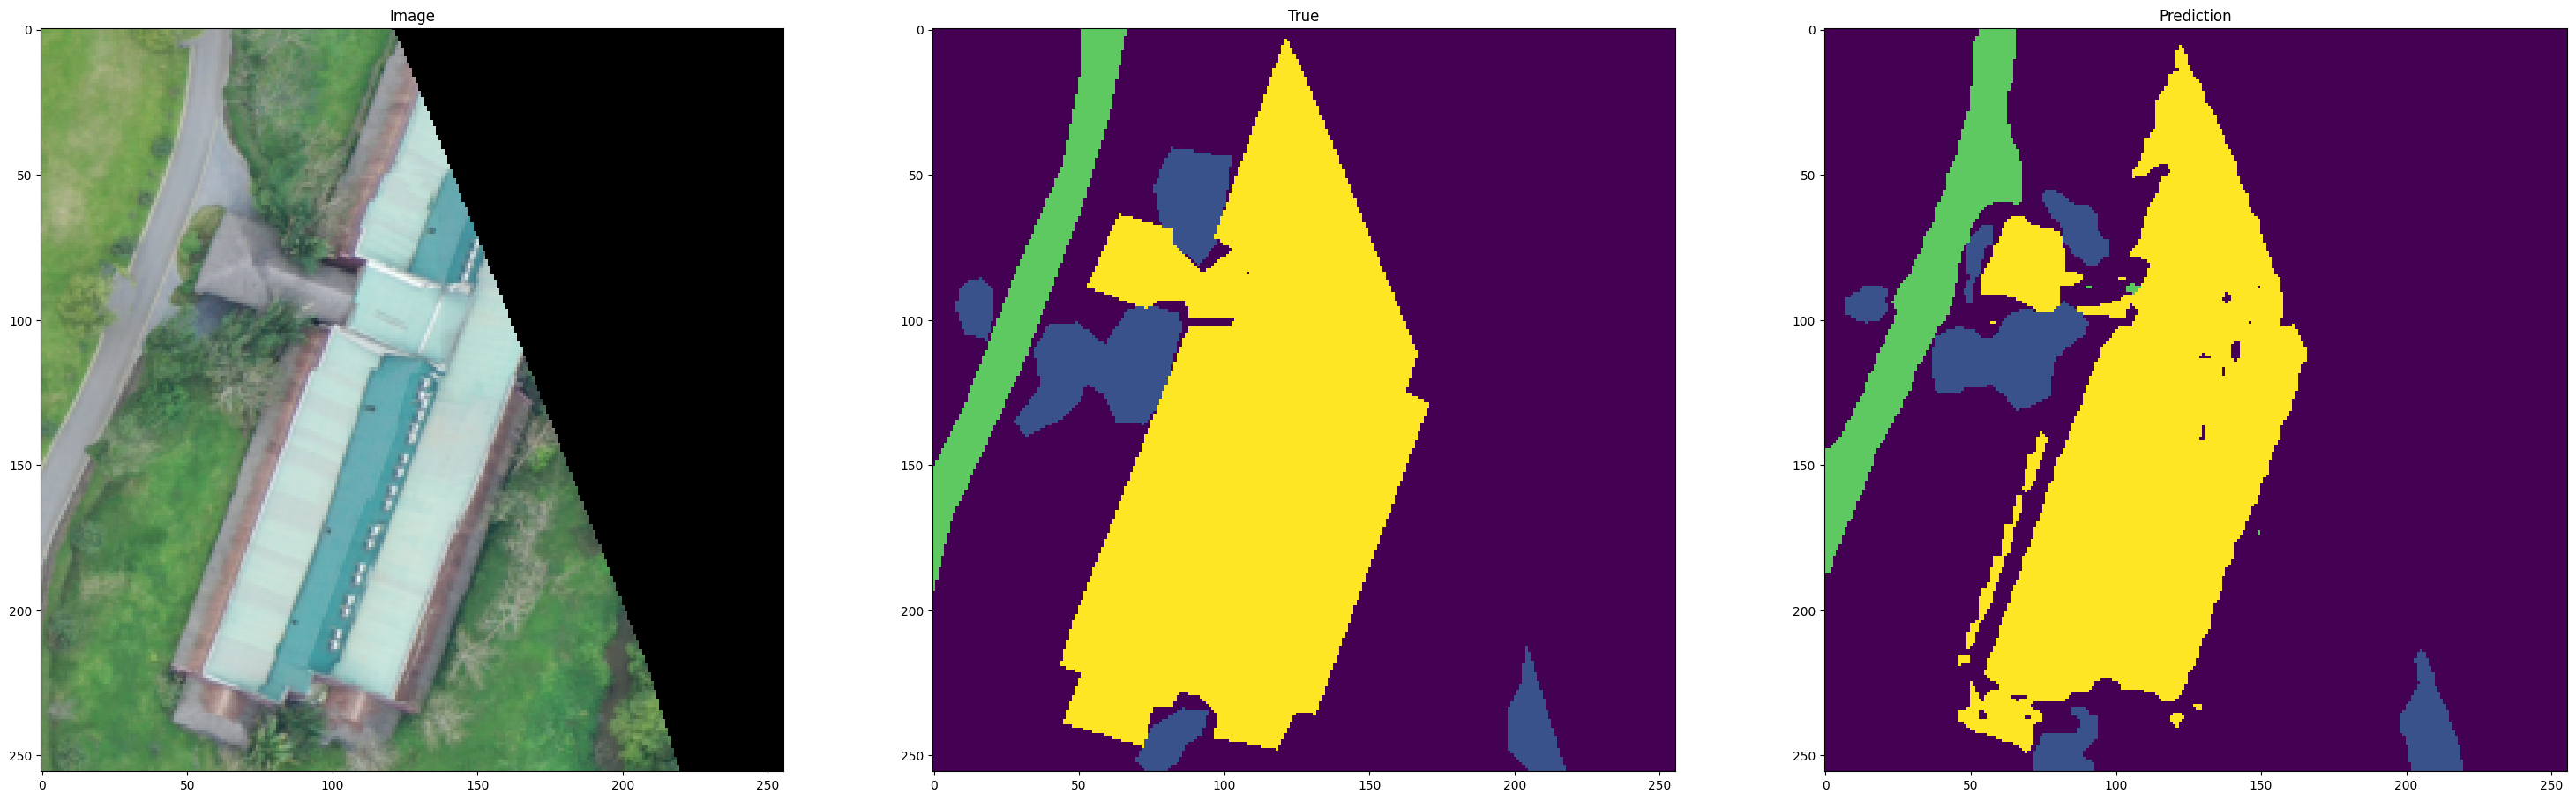

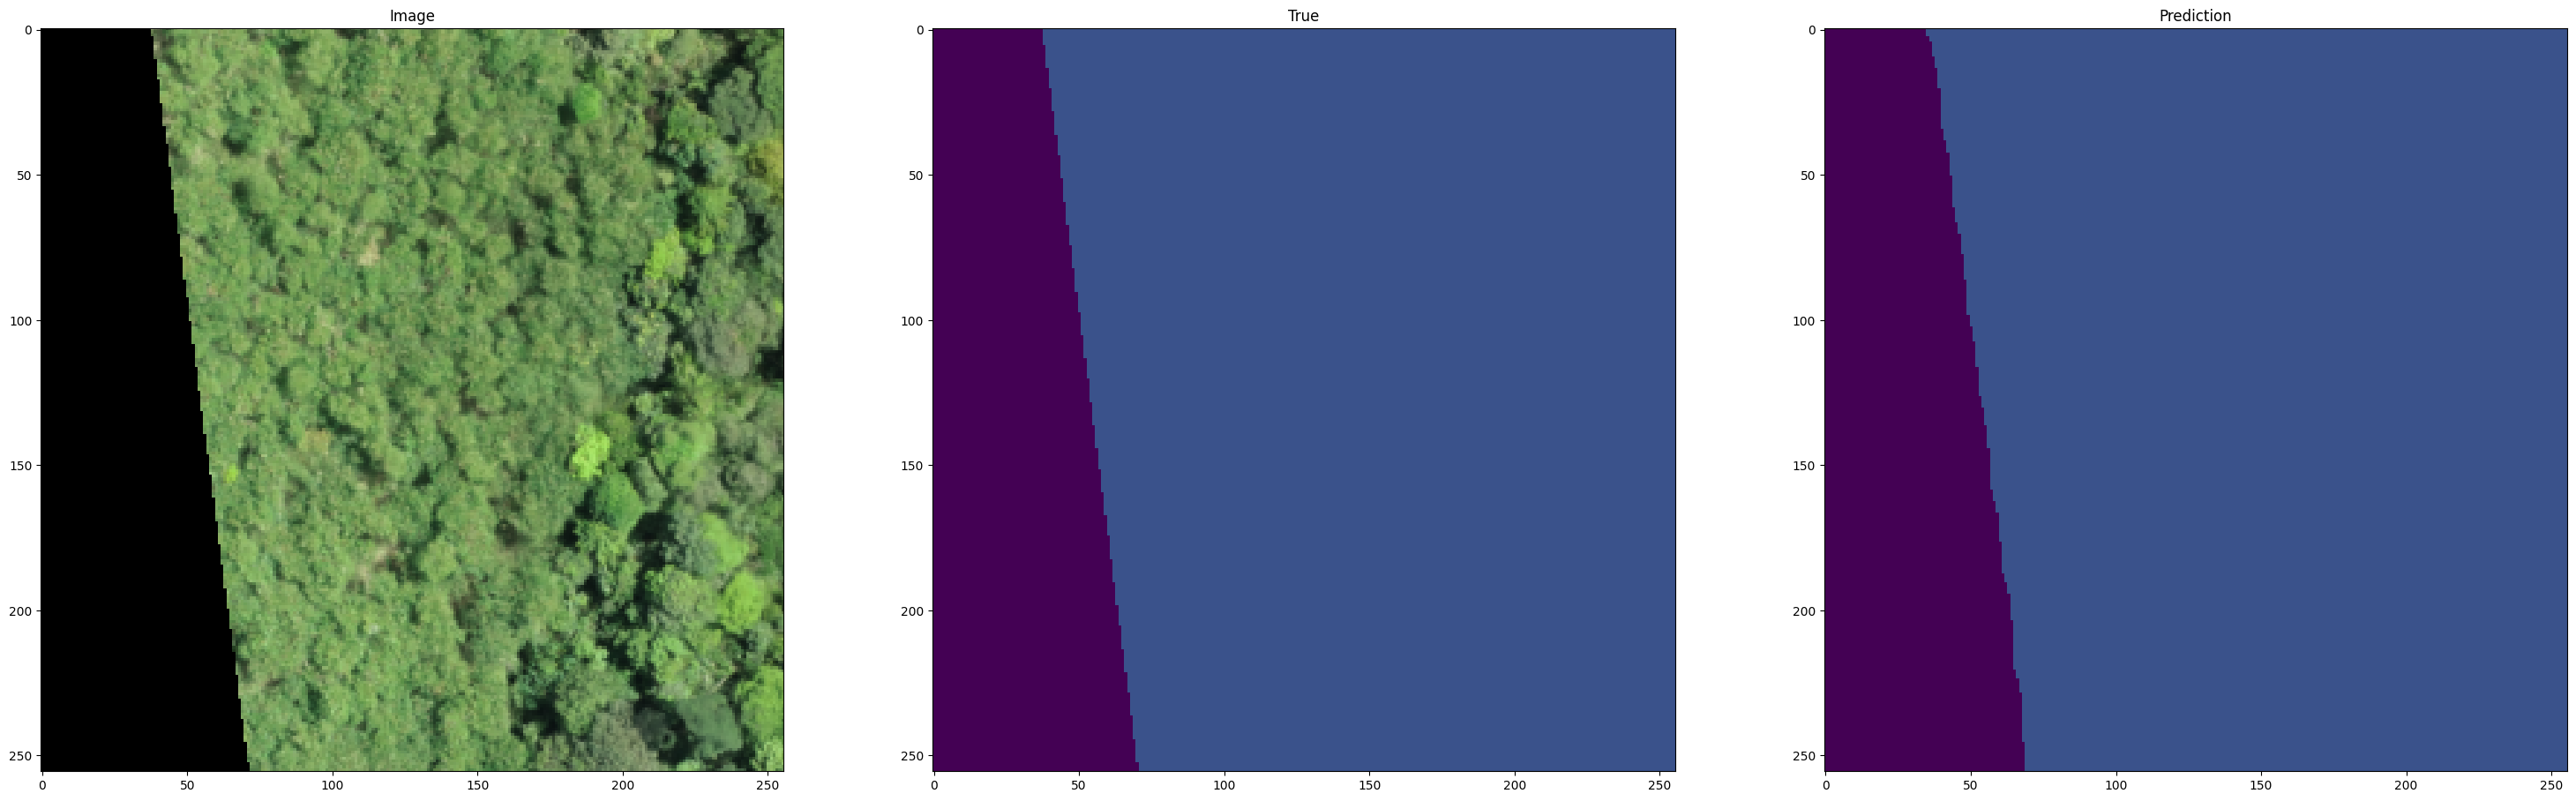

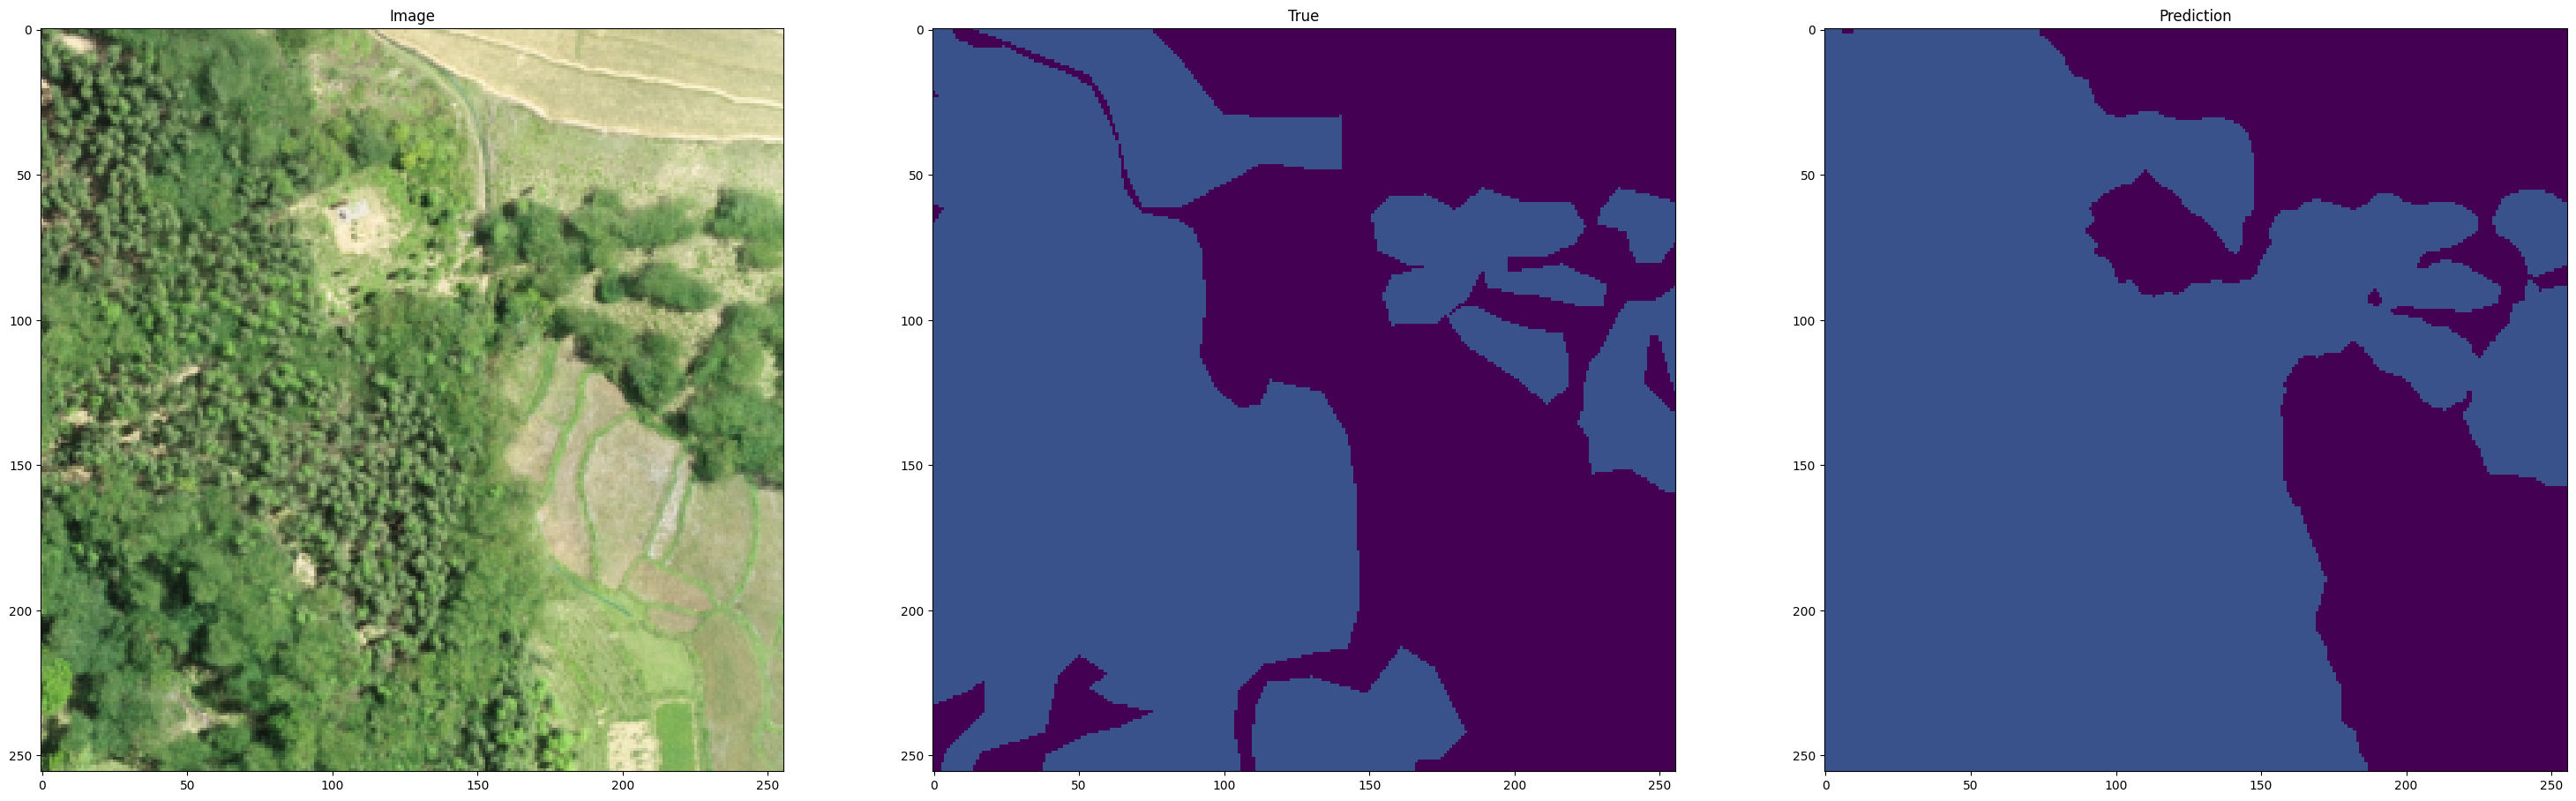

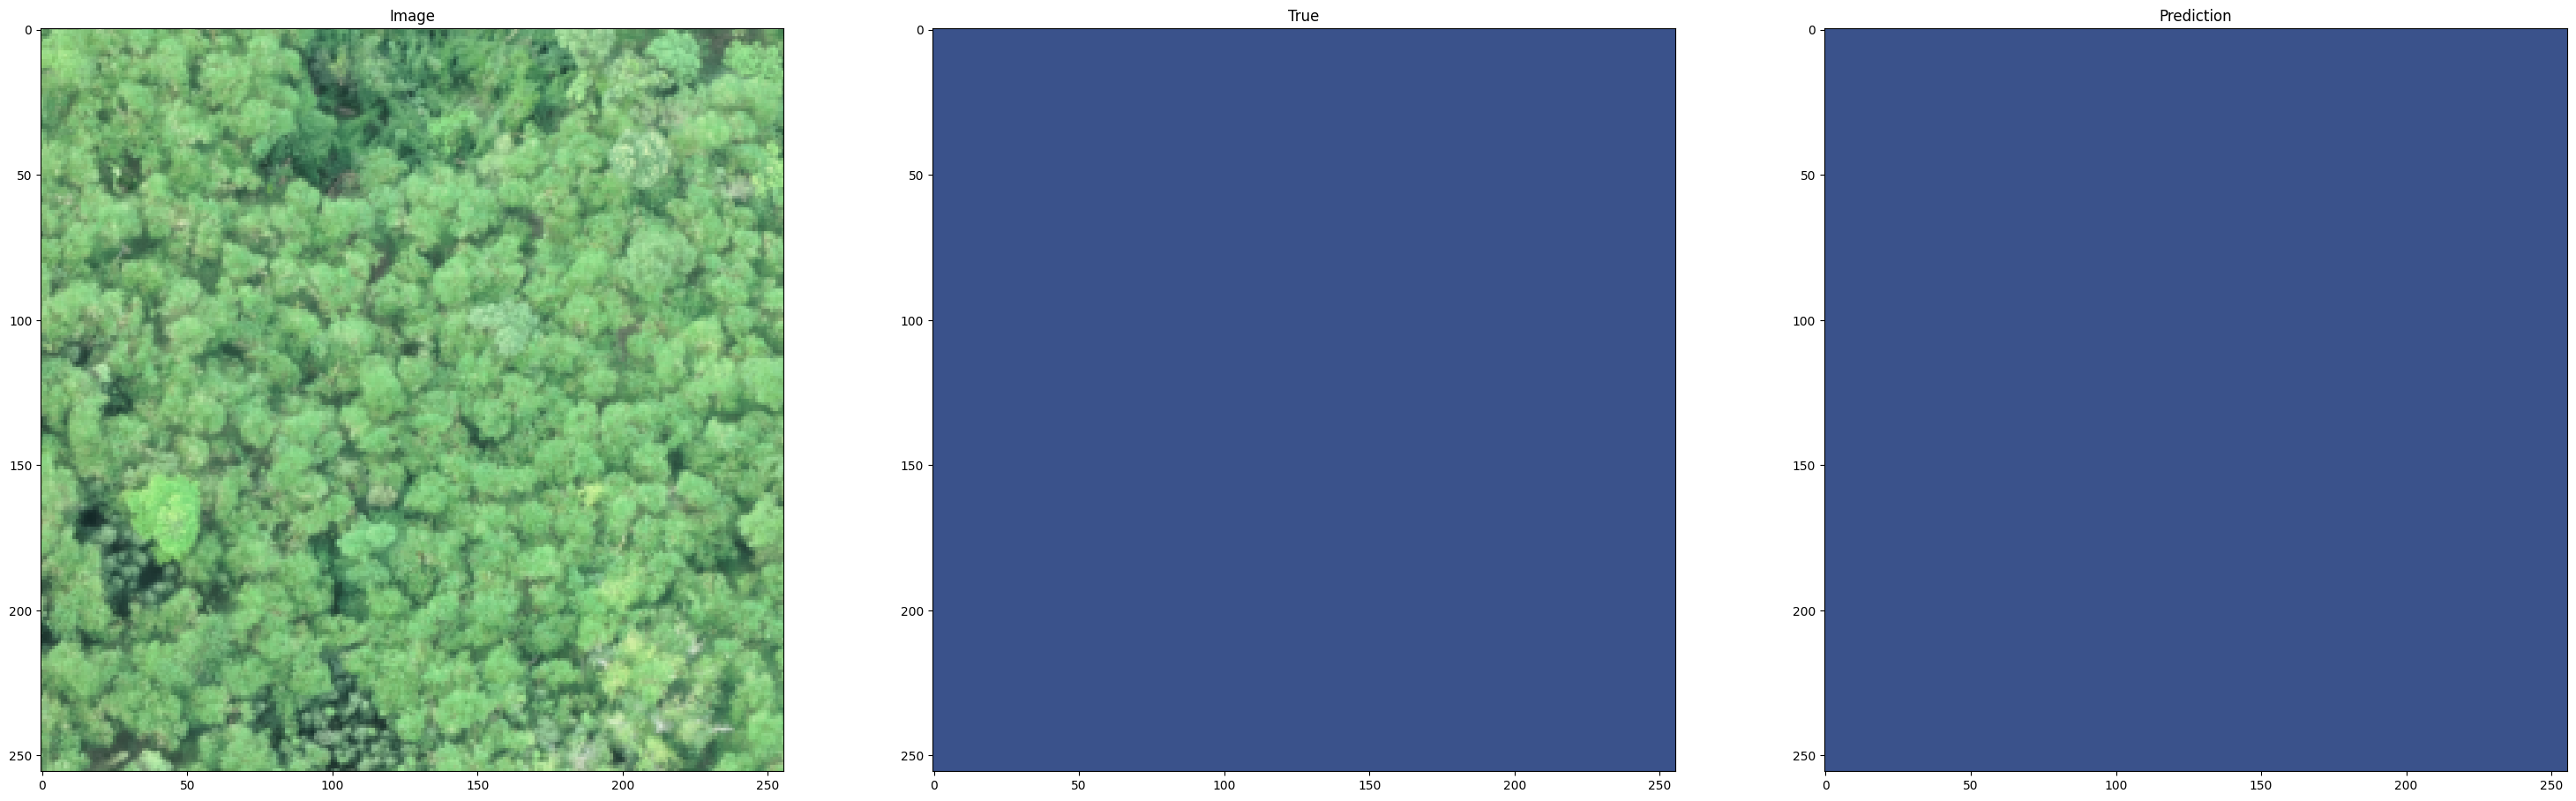

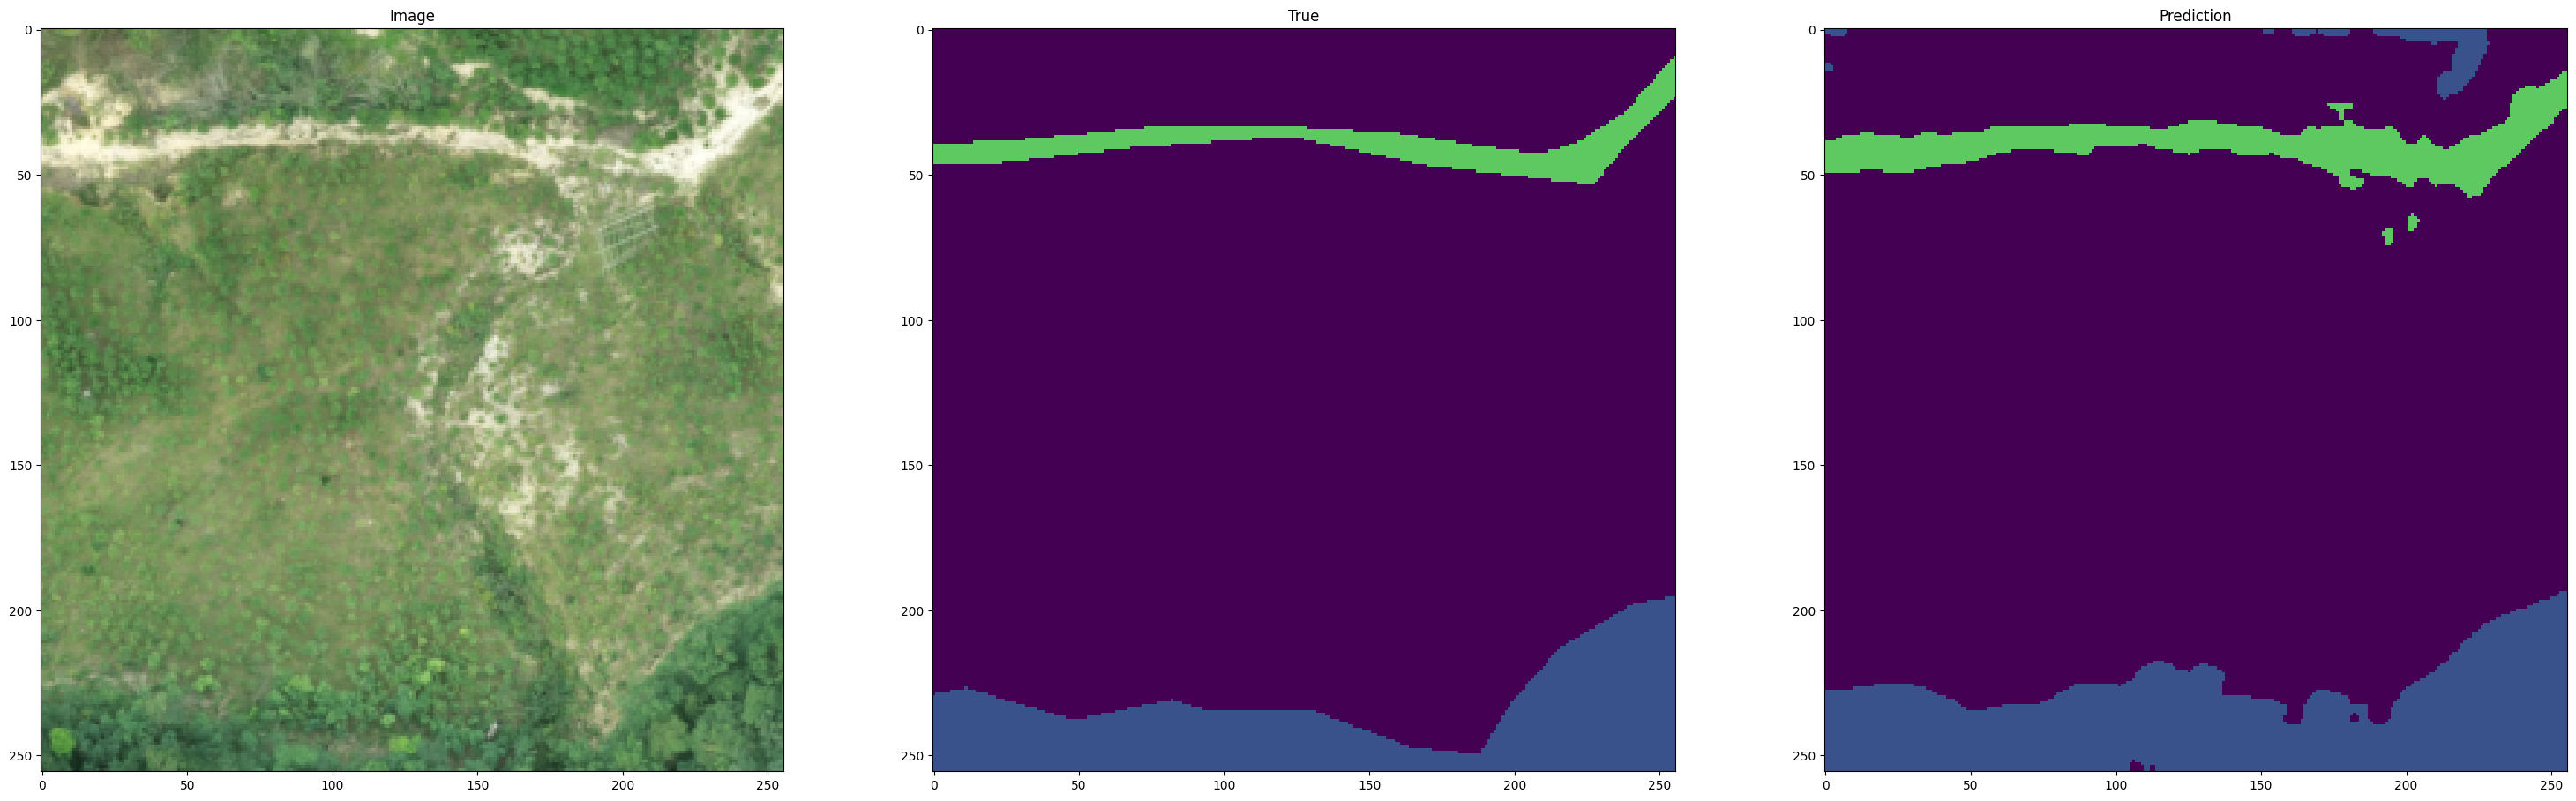

In [16]:
vmin = 0
vmax = 4

for i in range(5):

    image_number = random.randint(0, X_test.shape[0] - 1)

    plt.figure(figsize=(50, 12.5))

    plt.subplot(141)
    plt.title('Image')
    plt.imshow(X_test[image_number])

    plt.subplot(142)
    plt.title('True')
    true = y_test[image_number].argmax(axis=2)
    plt.imshow(true, vmin = vmin, vmax = vmax)

    plt.subplot(143)
    plt.title('Prediction')
    prediction = model.predict(np.expand_dims(X_test[image_number], 0))[0].argmax(axis=2)  # convert to 0-5 classes
    plt.imshow(prediction, vmin = vmin, vmax = vmax)


In [17]:
def calculate_iou(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = []

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores.append(0.0)  # Handle the case of no instances of a class
        else:
            iou_scores.append(intersection / union)

    return np.mean(iou_scores)

In [18]:
def calculate_iou_for_each_class(y_true, y_pred):
    num_classes = np.max(y_true) + 1  # Number of classes (assuming class indices start from 0)
    iou_scores = {}

    for class_id in range(num_classes):
        true_mask = y_true == class_id
        pred_mask = y_pred == class_id

        intersection = np.logical_and(true_mask, pred_mask).sum()
        union = np.logical_or(true_mask, pred_mask).sum()

        if union == 0:
            iou_scores[class_id] = 0.0  # Handle the case of no instances of a class
        else:
            iou_scores[class_id] = intersection / union

    return iou_scores


iou_scores = calculate_iou_for_each_class(X_label, X_pred)
for class_id, iou in iou_scores.items():
    print("IoU for class", class_id, ":", iou)


IoU for class 0 : 0.8664274188469815
IoU for class 1 : 0.8819773167307148
IoU for class 2 : 0.9145089986520692
IoU for class 3 : 0.6163006461593802
IoU for class 4 : 0.7540741461377475


In [19]:
miou = calculate_iou(X_label, X_pred)
print("Mean IoU:", miou)

Mean IoU: 0.8066577053053786
